In [ ]:
import os
import numpy as np
import random
from tqdm import tqdm
import sys
import joblib
import seaborn as sns
import pandas as pd
from scipy import interpolate
from sklearn import metrics
from scipy.stats import ttest_ind, ttest_1samp
from pymovements.gaze.transforms import pix2deg, pos2vel

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import argparse
from scipy.spatial import distance
from scipy.stats import ttest_ind, ttest_1samp



from tensorflow.keras.models import Model
from sp_eyegan.preprocessing import data_loader as data_loader
from sp_eyegan.model import contrastive_learner as contrastive_learner

%pylab inline
%load_ext autoreload
%autoreload 2

In [2]:
# params
dst_dir = 'results/'

In [3]:
models = ['EKYT',
         'ekyt_random_window_size_300_sd_0.05_sd_factor_1.25_embedding_size_128_stimulus_video_model_random_-1baseline_60',
         'CLRGAZE',
         'clrgaze_random_window_size_300_sd_0.05_sd_factor_1.25_embedding_size_512_stimulus_video_model_random_-1baseline_60',
         ]

In [4]:
folds = 5
popmean = 0.5
flag_trial_level_evaluation = True
five_sec_eval = False
num_trains = [-1,
              100,
              500,
              1000,
              5000,
              10000,
              50000,
             ]

model_heads = ['nn',
               'rf',
              ]

name_mapping = {'clrgaze':'CLRGaze',
                'ekyt':'EKYT',
                'CLRGAZE':'CLRGaze',
                'EKYT':'EKYT',
                }


overall_result_dicts = dict()
for num_train in num_trains:
    model_results_dicts = dict()
    print('num_train: ' + str(num_train))
    print('------------------------------------')
    for i in range(len(models)):
        for m_h in range(len(model_heads)):
            model_head = model_heads[m_h]
            cur_aucs = []
            cur_model = models[i] + '_fold0_gender.joblib'
            if num_train != -1:
                cur_model = cur_model.replace('_gender','_gender_num_train_' + str(num_train))
            if 'embedding_size' not in cur_model:
                model_name = name_mapping[cur_model.split('/')[-1].split('_')[0]] + ' (w/o pre-training)'
            else:
                model_name = name_mapping[cur_model.split('/')[-1].split('_')[0]] + ' (CP SPEyeGAN)'
            model_name += ' ' + model_head
            if 'w/o pre-training' in model_name and model_head != 'nn':
                break

            for fold in range(folds):
                cur_path = cur_model.replace('fold0','fold' + str(fold))
                try:
                    cur_result = joblib.load(dst_dir + cur_path)
                except:
                    print('not found: ' + str(cur_path))
                    continue
                    #try:
                    #    cur_result = joblib.load(result_dir + '/to_delete/' + cur_path)
                    #except:
                    #    continue
                test_subjects = np.array(cur_result['test_subjects'])
                test_label    = np.array(cur_result['test_label'])
                test_trials = np.array(cur_result['test_trials'])
                predictions_nn   = np.array(cur_result['predictions_nn'])
                predictions_rf   = np.array(cur_result['predictions_rf'])[:,1]
                predictions_distances   = np.array(cur_result['predictions_distances'])

                if model_head ==  'nn':
                    predictions = predictions_nn
                elif model_head == 'rf':
                    predictions = predictions_rf
                elif model_head == 'distances':
                    predictions = predictions_distances


                predictions[np.isnan(predictions)] = 0.0
                overall_auc = roc_auc_score(test_label, predictions)
                if five_sec_eval:
                    cur_aucs.append(overall_auc)
                else:
                    #print('overall_score: ' + str(overall_auc))

                    unique_subjects = list(np.unique(test_subjects))
                    #print('number of test subjects: ' + str(len(unique_subjects)))
                    u_label = []
                    u_preds = []
                    for u_s in range(len(unique_subjects)):
                        cur_subject = unique_subjects[u_s]
                        cur_instances = np.where(test_subjects == cur_subject)[0]
                        cur_scores = predictions[cur_instances]
                        cur_label = test_label[cur_instances]
                        cur_trials = test_trials[cur_instances]
                        if flag_trial_level_evaluation:
                            unique_trials = list(np.unique(cur_trials))
                            for t_s in range(len(unique_trials)):
                                cur_trial = unique_trials[t_s]
                                cur_instances = np.where(cur_trials == cur_trial)[0]
                                u_label.append(int(np.unique(cur_label[cur_instances])))
                                u_preds.append(np.mean(cur_scores[cur_instances]))
                        else:                
                            u_label.append(int(np.unique(cur_label)))
                            u_preds.append(np.mean(cur_scores))

                    subj_auc = roc_auc_score(u_label, u_preds)
                    cur_aucs.append(subj_auc)
                    #print(cur_model)
                    #sns.histplot(u_preds)
                    #plt.show()
                    #print('subj_auc: ' + str(subj_auc))

            model_results_dicts[model_name] = (cur_aucs, cur_model)
            
            better_random_pvalue = ttest_1samp(a=cur_aucs,popmean=popmean,alternative = 'greater').pvalue
            if better_random_pvalue < 0.05:
                cur_p_value_add_str = '*'
            else:
                cur_p_value_add_str = ''
                
            cur_p_value_model_str = ''
            if 'w/o' not in model_name:
                if model_name.startswith('EKYT'):
                    base_values = model_results_dicts['EKYT (w/o pre-training) nn'][0]
                elif model_name.startswith('CLRGaze'):
                    base_values = model_results_dicts['CLRGaze (w/o pre-training) nn'][0]
                tt_test_pvalue = ttest_ind(base_values,cur_aucs,alternative='two-sided').pvalue
                if tt_test_pvalue < 0.05 and np.mean(base_values) < np.mean(cur_aucs):
                    cur_p_value_model_str += '$\dagger$'
                else:
                    cur_p_value_model_str += ''
                model_name = model_name.replace('nn','fine-tuning').replace('rf','random forest')
            else:
                model_name = model_name.replace('nn','').strip()
            print('    ' + model_name + ' & ' +\
                  str(np.round(np.mean(cur_aucs), decimals = 2)) +\
                  ' $\pm$ ' + str(str(np.round(np.std(cur_aucs) / np.sqrt(folds), decimals = 2))) +\
                  cur_p_value_add_str + cur_p_value_model_str)# + ' folds: ' + str(len(cur_aucs))) 
            
            overall_result_dicts[model_name + '_num_train_' + str(num_train)] = cur_aucs

num_train: -1
------------------------------------
    EKYT (w/o pre-training) & 0.68 $\pm$ 0.01*
    EKYT (CP SPEyeGAN) fine-tuning & 0.68 $\pm$ 0.01*
    EKYT (CP SPEyeGAN) random forest & 0.65 $\pm$ 0.01*
    CLRGaze (w/o pre-training) & 0.66 $\pm$ 0.01*
    CLRGaze (CP SPEyeGAN) fine-tuning & 0.6 $\pm$ 0.02*
    CLRGaze (CP SPEyeGAN) random forest & 0.66 $\pm$ 0.01*
num_train: 100
------------------------------------
    EKYT (w/o pre-training) & 0.48 $\pm$ 0.04
    EKYT (CP SPEyeGAN) fine-tuning & 0.49 $\pm$ 0.01
    EKYT (CP SPEyeGAN) random forest & 0.59 $\pm$ 0.02*$\dagger$
    CLRGaze (w/o pre-training) & 0.5 $\pm$ 0.02
    CLRGaze (CP SPEyeGAN) fine-tuning & 0.48 $\pm$ 0.01
    CLRGaze (CP SPEyeGAN) random forest & 0.59 $\pm$ 0.02*$\dagger$
num_train: 500
------------------------------------
    EKYT (w/o pre-training) & 0.61 $\pm$ 0.03*
    EKYT (CP SPEyeGAN) fine-tuning & 0.52 $\pm$ 0.01*
    EKYT (CP SPEyeGAN) random forest & 0.59 $\pm$ 0.01*
    CLRGaze (w/o pre-training)

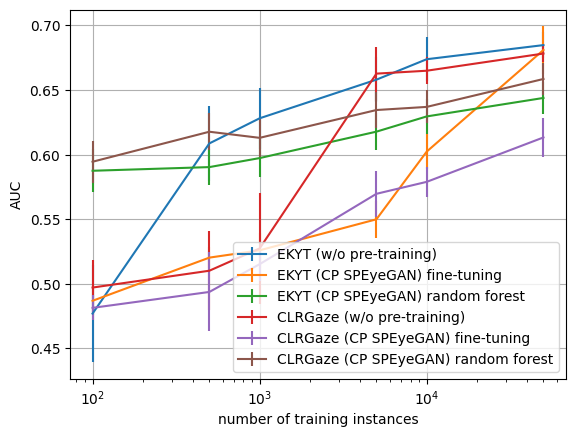

In [5]:
model_names = ['EKYT (w/o pre-training)',
                'EKYT (CP SPEyeGAN) fine-tuning',
                'EKYT (CP SPEyeGAN) random forest',
                'CLRGaze (w/o pre-training)',
                'CLRGaze (CP SPEyeGAN) fine-tuning',
                'CLRGaze (CP SPEyeGAN) random forest',
              ]

use_num_trains = [100,
              500,
              1000,
              5000,
              10000,
              50000,
             ]

for model_name in model_names:
    mean_aucs = []
    std_aucs = []
    for num_train in use_num_trains:
        cur_aucs = overall_result_dicts[model_name + '_num_train_' + str(num_train)]
        mean_aucs.append(np.mean(cur_aucs))
        std_aucs.append(np.std(cur_aucs) / np.sqrt(len(cur_aucs)))
    plt.errorbar(use_num_trains,mean_aucs,std_aucs, label=model_name)
plt.legend()
plt.xlabel('number of training instances')
plt.ylabel('AUC')
plt.xscale('log')
plt.grid()
plt.savefig('plots/gender_all_models.pdf', dpi = 300)
plt.show()

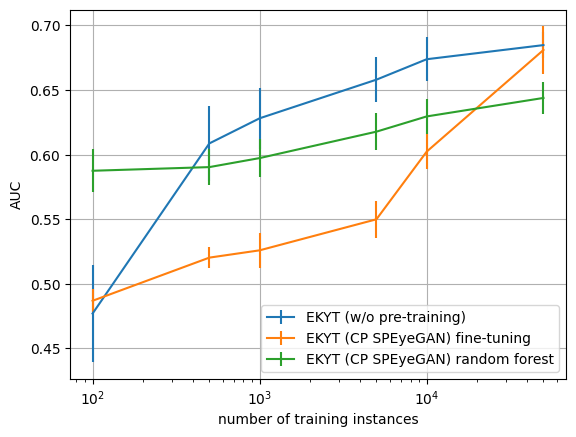

In [6]:
model_names = ['EKYT (w/o pre-training)',
                'EKYT (CP SPEyeGAN) fine-tuning',
                'EKYT (CP SPEyeGAN) random forest',
              ]

use_num_trains = [100,
              500,
              1000,
              5000,
              10000,
              50000,
             ]

for model_name in model_names:
    mean_aucs = []
    std_aucs = []
    for num_train in use_num_trains:
        cur_aucs = overall_result_dicts[model_name + '_num_train_' + str(num_train)]
        mean_aucs.append(np.mean(cur_aucs))
        std_aucs.append(np.std(cur_aucs) / np.sqrt(len(cur_aucs)))
    plt.errorbar(use_num_trains,mean_aucs,std_aucs, label=model_name)
plt.legend()
plt.xlabel('number of training instances')
plt.ylabel('AUC')
plt.xscale('log')
plt.grid()
plt.savefig('plots/gender_ekyt.pdf', dpi = 300)
plt.show()

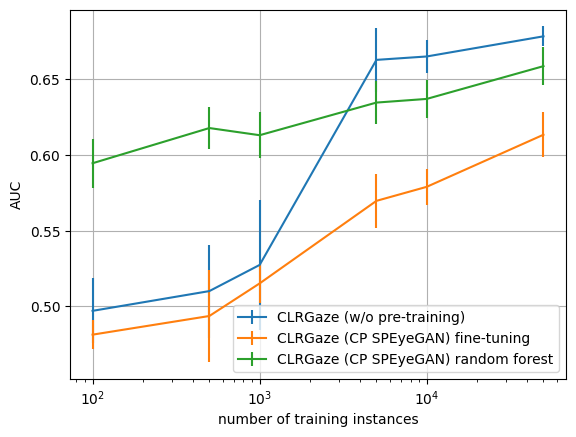

In [7]:
model_names = [
                'CLRGaze (w/o pre-training)',
                'CLRGaze (CP SPEyeGAN) fine-tuning',
                'CLRGaze (CP SPEyeGAN) random forest',
              ]

use_num_trains = [100,
              500,
              1000,
              5000,
              10000,
              50000,
             ]

for model_name in model_names:
    mean_aucs = []
    std_aucs = []
    for num_train in use_num_trains:
        cur_aucs = overall_result_dicts[model_name + '_num_train_' + str(num_train)]
        mean_aucs.append(np.mean(cur_aucs))
        std_aucs.append(np.std(cur_aucs) / np.sqrt(len(cur_aucs)))
    plt.errorbar(use_num_trains,mean_aucs,std_aucs, label=model_name)
plt.legend()
plt.xlabel('number of training instances')
plt.ylabel('AUC')
plt.xscale('log')
plt.grid()
plt.savefig('plots/gender_clrgaze.pdf', dpi = 300)
plt.show()